# Justificacion:

### 1º Modelo

En el primer modelo He utilizado una regresion n logística con diferentes valores del parámetro de regularización C.Este modelo utiliza una lista de valores de C predefinidos, c_params, y un modelo de regresión logística con el algoritmo de optimización lbfgs. El conjunto de entrenamiento y el conjunto de prueba se utilizan para ajustar y evaluar el modelo.

Para cada valor de C en la lista de parámetros c_params, se ajusta un modelo de regresión logística y se evalúa su precisión en el conjunto de prueba y el conjunto de entrenamiento. La precisión se mide con la función accuracy_score del paquete sklearn.metrics.

podemos utilizar  este modelo para seleccionar el valor óptimo del parámetro de regularización C que resulte en el mejor desempeño del modelo en el conjunto de prueba y evitar el sobreajuste en el modelo

### 2 Modelo


En el modelo utiliza una capa de Embedding para representar cada palabra en una reseña amazon como un vector denso de números reales, seguido de una capa GRU para capturar las relaciones entre las palabras en una secuencia. La capa GRU está seguida por una capa densa con una función de activación sigmoide para producir una salida de clasificación binaria. El modelo se compila con la función de pérdida de entropía cruzada binaria y se entrena con el algoritmo de optimización Adam. Finalmente, el modelo se evalúa en el conjunto de prueba para evaluar su rendimiento en términos de precisión y pérdida.


In [1]:


import json
import pandas as pd
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
df = pd.read_csv("df_limpio_procesado.csv",index_col=None)
df = df.drop('Unnamed: 0', axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98891 entries, 0 to 98890
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sentiment         98891 non-null  int64 
 1   review            98880 non-null  object
 2   sentiment_label   98891 non-null  int64 
 3   review_procesada  98880 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.0+ MB


In [2]:
df.head()

,sentiment,review,sentiment_label,review_procesada
0,4,Online version easier to use in my opinion. St...,0,online version easier use still good misc form...
1,4,everything was as advertised and performed as ...,0,everything advertised performed
2,1,I first purchased a Garmin Nuvi 650 GPS near t...,1,first purchased garmin nuvi gps near end error...
3,5,I bought this for my daughters (2nd and 3rd gr...,0,bought daughters love complete computer module...
4,5,excellent product,0,excellent product


In [3]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)


In [4]:
df.dropna(inplace=True)
df.head()

,sentiment,review,sentiment_label,review_procesada
0,4,Online version easier to use in my opinion. St...,0,online version easier use still good misc form...
1,4,everything was as advertised and performed as ...,0,everything advertised performed
2,1,I first purchased a Garmin Nuvi 650 GPS near t...,1,first purchased garmin nuvi gps near end error...
3,5,I bought this for my daughters (2nd and 3rd gr...,0,bought daughters love complete computer module...
4,5,excellent product,0,excellent product


# 1º Modelo Regresion Lineal

### MODELADO

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review_procesada'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [15]:
X_train.iloc[:10]

87430    check item pay know market use unable download...
4609     game combines insane graphics extreme speeds b...
32014    overall games good help children learn little ...
20134    using forever probably continue nothing perfec...
52606    excellent software excellent establishing mana...
43886    used trend many satisfied trend aware use late...
83491    app allowed read many books excess last year g...
6341     reading reviews wacom tablets saw someone ment...
8358     issues previous antivirus software great one w...
36711                   best free antivirus paid antivirus
Name: review_procesada, dtype: object

In [16]:
y_train.iloc[:10]

87430    1
4609     0
32014    1
20134    0
52606    0
43886    0
83491    0
6341     0
8358     0
36711    0
Name: sentiment_label, dtype: int64

# Extracción de features

In [67]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=5000,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=5000, min_df=3, strip_accents='ascii')

In [68]:
print(list(cv.vocabulary_.items())[:20])

[('check', 655), ('item', 2299), ('pay', 3097), ('know', 2364), ('market', 2629), ('use', 4733), ('unable', 4661), ('download', 1255), ('cause', 605), ('app', 202), ('supported', 4342), ('latest', 2403), ('apple', 212), ('time', 4512), ('game', 1803), ('insane', 2197), ('graphics', 1894), ('extreme', 1551), ('speeds', 4160), ('fits', 1682)]


## TF-IDF scores del training set y test set

In [69]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Palabras con el TF-IDF en alguna review

In [90]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 55354
Sentiment: 0
Review: actually prefer online version bit better offline sometimes interface gets confusing great synced


In [91]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 55354:
              tfidf
synced     0.422171
offline    0.420334
confusing  0.321537
prefer     0.300811
sometimes  0.274163
gets       0.270017
interface  0.243827
actually   0.232266
bit        0.231594
online     0.224130

Top 10 words with lowest TF_IDF in the review 55354:
              tfidf
prefer     0.300811
sometimes  0.274163
gets       0.270017
interface  0.243827
actually   0.232266
bit        0.231594
online     0.224130
better     0.190183
version    0.160911
great      0.154310


## $\chi²$ scores

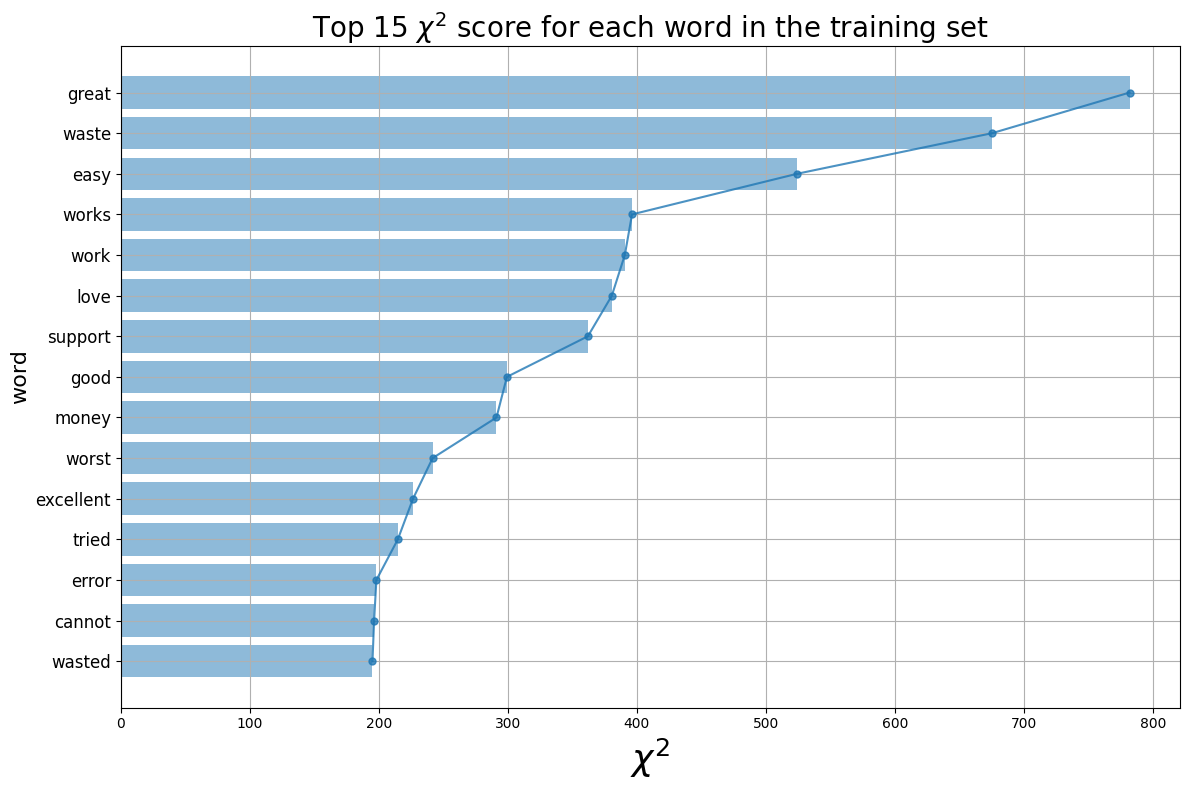

In [72]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [84]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=400)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.7502831715210356
Accuracy for C=0.05: 0.8279126213592233
Accuracy for C=0.25: 0.8574029126213593
Accuracy for C=0.5: 0.8618527508090615
Accuracy for C=1: 0.8648058252427184
Accuracy for C=10: 0.8617313915857605


# Metricas

In [85]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[16088  1429]
 [ 1989  5214]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     17517
           1       0.78      0.72      0.75      7203

    accuracy                           0.86     24720
   macro avg       0.84      0.82      0.83     24720
weighted avg       0.86      0.86      0.86     24720

Accuracy score:0.8617313915857605


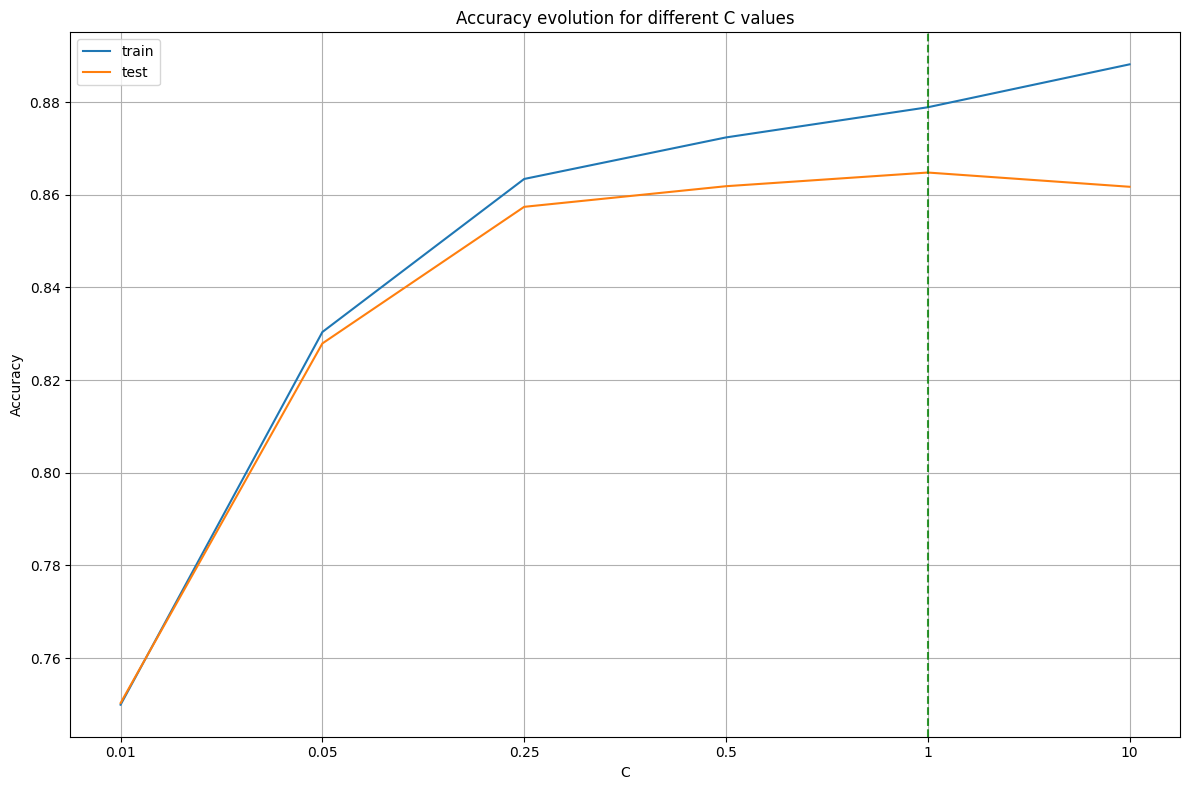

In [86]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [ ]:
# valor de c ideal 0="1"

# Prediccion

In [87]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [88]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 23989
Actual sentiment: 1
Prediction: [1]

Review no. 82102
Actual sentiment: 0
Prediction: [0]

Review no. 34841
Actual sentiment: 1
Prediction: [1]

Review no. 65668
Actual sentiment: 0
Prediction: [0]

Review no. 28777
Actual sentiment: 0
Prediction: [0]

Review no. 73915
Actual sentiment: 0
Prediction: [0]

Review no. 90975
Actual sentiment: 0
Prediction: [0]

Review no. 75724
Actual sentiment: 0
Prediction: [0]

Review no. 30000
Actual sentiment: 1
Prediction: [1]

Review no. 94588
Actual sentiment: 1
Prediction: [1]


### Prediccion hecha sobre una rewiev cogida de amazon con una estrella.

In [57]:
rewiev_amazon="Beware of tech support and bad or missing files I got the new TurboTax program as a download and it came over easy. I had the 2021 program and it was great. This time I tried to install it 4 times – I even deleted it, then tried aagain but still no luck. Error message was: (File’_ssc.rabgrp_nommoc_lacol_tib23_rgnerepw) cannot be found times in Data1.cab I went to Intuit site found tech support and chatted with a picture and a name (who knows if they are who they say they are). I gave them details including the error message. They said they would connect me to a technician BUT THERE WOULD BE A $1 CHARGE. LIKE A FOOL I DID IT.The technician said he was a third-party contractor. He had a nice picture and his name was Gupta. He said he had 4 years’ experience. I told him I had 17 years as tech support in a multiple school districts. He said I would need to give him REMOTE ACCESS to my computer – FOR $39.00. I said NO – years ago my colleague got identity stolen that way. There was many 10 – 15-minute pauses while he looked in his instruction book or talked to someone else. He did not seem very experienced except for reading prompts from their book.Then 50 minutes in he asked me to describe the problem. I reminded him that I had done that in detail 50 minutes ago. It was obvious that the error message indicates a corrupt or missing file. This is not something these “Technicians” can handle with their books. I told him what I needed was to send me a clean download that was not corrupted, or a patch. No response. I chatted several more minutes and said I would report this, and said good bye. Later I did get a message to call another number if I still needed help. I will try to go straight to INTUIT and Amazon. I did request several times to return my $1.00 since they were no help. Wish me luck!Sometimes a site or vendor may send out corrupted programs to drum up support money or gain access. If you have had this same problem contact Amazon."


In [95]:
print(lr.predict(cv.transform([rewiev_amazon])))

[1]


In [7]:
import gensim
import multiprocessing as mp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [8]:
max = 0
mean = []
for example in X_train:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

In [9]:
sum(mean) / len(mean)

210.52613268608414

In [10]:
max

14389

In [41]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Embedding, Dropout, GRUV2
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Embedding,  Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# definir tamaño máximo del vocabulario

vocab_size = 100

# cargar conjunto de datos
# y dividirlo en conjuntos de entrenamiento y prueba


train_reviews =X_train # lista de reseñas 
train_sentiments =  y_train # lista de etiquetas de sentimiento
test_reviews = X_test # lista de reseñas 
test_sentiments = y_test # lista de etiquetas de sentimiento


# tokenizar el conjunto de datos
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_reviews)

train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# ajustar la longitud de las secuencias
max_length = 50
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# definir la arquitectura de la Red GRU
embedding_dim = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRUV2(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# entrenar el modelo
H=model.fit(train_sequences, train_sentiments, validation_data=(test_sequences, test_sentiments), epochs=10, batch_size=64)

# evaluar el modelo
loss, accuracy = model.evaluate(test_sequences, test_sentiments)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            3200      
                                                                 
 gru_1 (GRU)                 (None, 100)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,501
Trainable params: 43,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1159/1159 [==============================] - 76s 63ms/step - loss: 0.6059 - accuracy: 0.7068 - val_loss: 0.6038 - val_accuracy: 0.7086
Epoch 2/10
1159/1159 [==============================] - 72s 62ms/step - loss: 0.4796 - accuracy: 0.7699 - val_loss: 0.4487 - val_accuracy: 0.7841
Epoch 3/10
1159/1

[INFO]: Evaluando red neuronal...


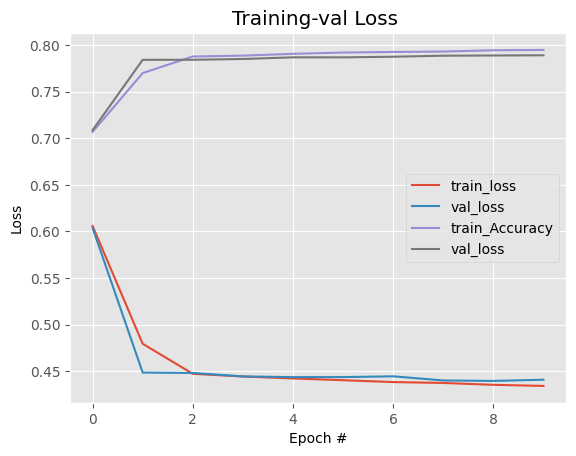

In [54]:
print("[INFO]: Evaluando red neuronal...")

    
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_Accuracy")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_loss")
 
 
plt.title("Training-val Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

PREDECIR UNA REVIEW:

In [62]:
# Preprocesar el texto
text = "Beware of tech support and bad or missing files I got the new TurboTax program as a download and it came over easy. I had the 2021 program and it was great. This time I tried to install it 4 times – I even deleted it, then tried aagain but still no luck. Error message was: (File’_ssc.rabgrp_nommoc_lacol_tib23_rgnerepw) cannot be found times in Data1.cab I went to Intuit site found tech support and chatted with a picture and a name (who knows if they are who they say they are). I gave them details including the error message. They said they would connect me to a technician BUT THERE WOULD BE A $1 CHARGE. LIKE A FOOL I DID IT.The technician said he was a third-party contractor. He had a nice picture and his name was Gupta. He said he had 4 years’ experience. I told him I had 17 years as tech support in a multiple school districts. He said I would need to give him REMOTE ACCESS to my computer – FOR $39.00. I said NO – years ago my colleague got identity stolen that way. There was many 10 – 15-minute pauses while he looked in his instruction book or talked to someone else. He did not seem very experienced except for reading prompts from their book.Then 50 minutes in he asked me to describe the problem. I reminded him that I had done that in detail 50 minutes ago. It was obvious that the error message indicates a corrupt or missing file. This is not something these “Technicians” can handle with their books. I told him what I needed was to send me a clean download that was not corrupted, or a patch. No response. I chatted several more minutes and said I would report this, and said good bye. Later I did get a message to call another number if I still needed help. I will try to go straight to INTUIT and Amazon. I did request several times to return my $1.00 since they were no help. Wish me luck!Sometimes a site or vendor may send out corrupted programs to drum up support money or gain access. If you have had this same problem contact Amazon."

text_sequence = tokenizer.texts_to_sequences([text])
text_sequence = pad_sequences(text_sequence, maxlen=max_length, padding='post')

# Hacer la predicción
prediction = model.predict(text_sequence)

# Obtener la etiqueta de sentimiento correspondiente
sentiment_label = "Positivo" if prediction[0] >=3 else "0: Negativo"
print("La etiqueta de sentimiento del texto es:", sentiment_label)

1/1 [==============================] - 0s 32ms/step
La etiqueta de sentimiento del texto es: 0: Negativo


Coincide en el acierto con el modelo de regrsion lineal y prersenta un Test accuracy: 0.7889562845230103.Quizas no necesite tantas epocas para entrenar el modelo.podria hacer mas pruebas intentando ajustar los parametros de vocabulario, epocas, bach-size, etc..